# MCM2018 code sheet

Following python packages have been used in this code sheet

* [numpy](http://www.numpy.org/)

* [pandas](https://matplotlib.org/)

* [matplotlib](https://matplotlib.org/)

* [sklearn](scikit-learn.org/)

## package import and a little preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn_modified')    #set plot style
idx = pd.IndexSlice

## Data import and integrity check

In [2]:
msncodes = pd.read_excel('ProblemCData.xlsx',sheet_name='msncodes')
msncodes.head()    #.head() method is to take a look at the first 5 rows of it

,MSN,Description,Unit
0,ABICB,Aviation gasoline blending components consumed...,Billion Btu
1,ABICP,Aviation gasoline blending components consumed...,Thousand barrels
2,ARICB,Asphalt and road oil consumed by the industria...,Billion Btu
3,ARICD,Asphalt and road oil price in the industrial s...,Dollars per million Btu
4,ARICP,Asphalt and road oil consumed by the industria...,Thousand barrels


In [3]:
seeds = pd.read_excel('ProblemCData.xlsx',sheet_name='seseds')
seeds = seeds.merge(pd.DataFrame({'StateCode':['AZ','CA','NM','TX'],
              'State':['Arizona','California','New Mexico','Texas']}),)
seeds.head()

,MSN,StateCode,Year,Data,State
0,ABICB,AZ,1960,0.0,Arizona
1,ABICB,AZ,1961,0.0,Arizona
2,ABICB,AZ,1962,0.0,Arizona
3,ABICB,AZ,1963,0.0,Arizona
4,ABICB,AZ,1964,0.0,Arizona


combine these 2 table according to MSN as following:

**outer** means combine them with **union** method

In [4]:
agg = pd.merge(msncodes,seeds,how='outer')
agg.loc[:,'energy_type'] = agg.loc[:,'MSN'].str[:2]
agg.loc[:,'consuming_sector'] = agg.loc[:,'MSN'].str[2:4]
agg.loc[:,'dtype'] = agg.loc[:,'MSN'].str[4]

agg.head()

,MSN,Description,Unit,StateCode,Year,Data,State,energy_type,consuming_sector,dtype
0,ABICB,Aviation gasoline blending components consumed...,Billion Btu,AZ,1960.0,0.0,Arizona,AB,IC,B
1,ABICB,Aviation gasoline blending components consumed...,Billion Btu,AZ,1961.0,0.0,Arizona,AB,IC,B
2,ABICB,Aviation gasoline blending components consumed...,Billion Btu,AZ,1962.0,0.0,Arizona,AB,IC,B
3,ABICB,Aviation gasoline blending components consumed...,Billion Btu,AZ,1963.0,0.0,Arizona,AB,IC,B
4,ABICB,Aviation gasoline blending components consumed...,Billion Btu,AZ,1964.0,0.0,Arizona,AB,IC,B


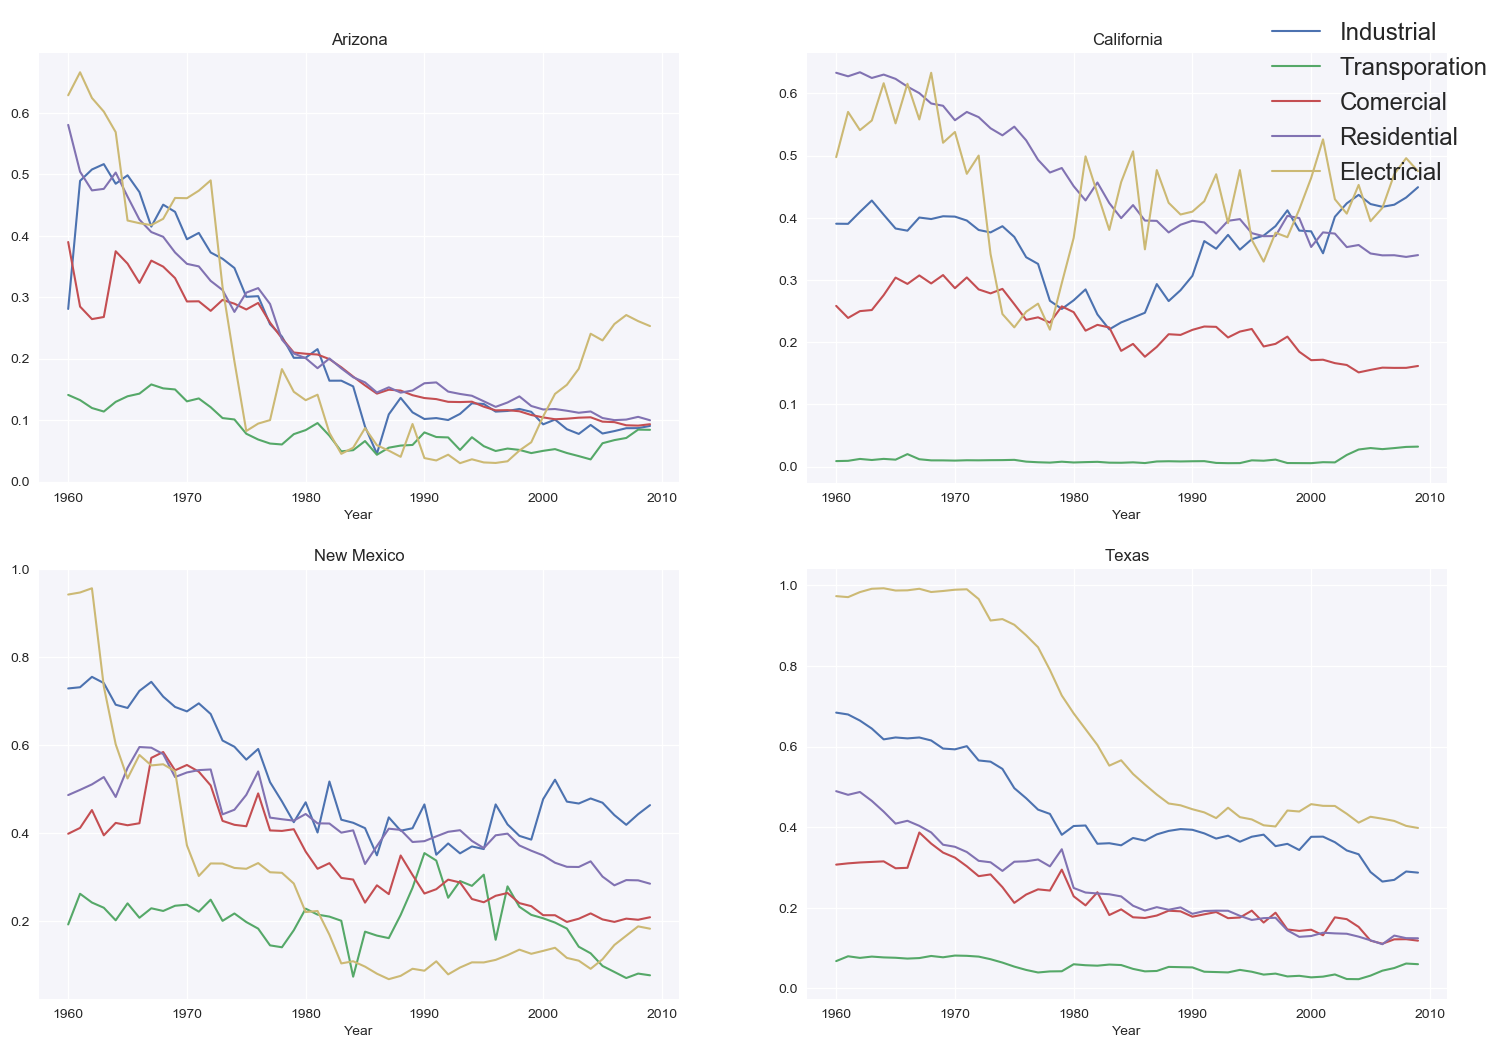

In [5]:
fig, ax = plt.subplots(2,2,figsize=(16,11),dpi=100)
ax = ax.flatten()
for each,i in zip(agg.State.unique(),(range(4))):
    btu = agg[(agg.State == each)&(agg.dtype == 'B')].\
        pivot_table('Data',['Year','energy_type'],'consuming_sector')
    ph = agg[(agg.State == each)&(agg.dtype == 'P')].\
        pivot_table('Data',['Year','energy_type'],'consuming_sector')
    cvt = agg[(agg.State == each)&(agg.dtype == 'K')].\
        pivot_table('Data',['Year','energy_type'],'consuming_sector')

    btu = btu.add((ph[btu.isna()]*cvt),fill_value=0)
    
    clean_ratio = pd.DataFrame()
    for sector,ind in zip(('IC','AC','CC','RC','EI'),\
                      ('Industrial','Transporation','Comercial','Residential','Electricial')):
    # ('EM','GE','HY')#'EM','GE','HY','SO','GO','WY',
        clean_ratio[ind] = \
        btu[sector].unstack().loc[:,('EM','GE','HY','SO','GO','WY','NG')].sum(axis = 1)/\
        btu[sector].unstack().loc[:,'TE']
    clean_ratio.plot(ax=ax[i], legend=False);
    ax[i].set_title(each)
# fig.set_tight_layout(True)
fig.legend(fontsize = 'xx-large')
# plt.savefig('each State\'s each sector\'s clean&renewable energy ratio.jpg')
plt.show()

In [6]:
any(ph[btu.isna()].values.flatten())

True

This line of code is to test whether data in Btu is missing and simtaneously data in physical units not missing

*True* tells us we can gain an more sufficient dataset by converting physical units to Btu.

And thus we get a combined,more sufficient data :

In [7]:
for each,name in ((len(msncodes.MSN.unique()),'msncodes'),
                  (len(seeds.MSN.unique()),'seeds'),
                  (len(agg.MSN.unique()),'combined')):
    print('number of MSN items in {0:10}:'.format(name),each)

number of MSN items in msncodes  : 605
number of MSN items in seeds     : 583
number of MSN items in combined  : 607


In [8]:
agg[agg['Description'].isna()].MSN.unique()

array(['GETXV', 'HYTXV'], dtype=object)

The result indicates that not all described item has it's place,and there are 2 items of MSN in seeds lack of Description.

so drop those insufficient data, and we should obtain 583 - (607 - 605) = 581 different MSN items.

Let's check it out :

In [9]:
agg.dropna(inplace=True)
len(agg.MSN.unique())

581

As expected!

## Categorization and analysis

### categorize items by energy form

In [10]:
energy_form_cat = ['CLTXB','NGTXB','PMTCB','BMTCB','GETXB','HYTCB','SOTXB']
engformap = ['Coal','Natrual gas','Petroleum','Biomass','Geothermal',
             'Hydroelectricity','Photovolaic&Solar']
engformap = pd.DataFrame({'MSN':energy_form_cat,'energy form':engformap})
# engformap.merge(msncodes.set_index('MSN').loc[energy_form_cat,:].reset_index())

energy_form = agg.set_index('MSN').loc[energy_form_cat,:].reset_index()

engtype = ['Biomass', 'Geothermal', 'Hydroelectricity', 'Photovolaic&Solar',
           'Natrual gas', 'Coal','Petroleum']
clean = [True, True, True, True, True, False, False]
renewable = [True, True, True, True, False, False, False]
clnre = pd.DataFrame({'energy form':engtype,'clean':clean,'renewable':renewable})

energy_form = energy_form.merge(engformap).merge(clnre)
energy_form.drop(columns=['Description']).head()

,MSN,Unit,StateCode,Year,Data,State,energy_type,consuming_sector,dtype,energy form,clean,renewable
0,CLTXB,Billion Btu,AZ,1960.0,209.57935,Arizona,CL,TX,B,Coal,False,False
1,CLTXB,Billion Btu,AZ,1961.0,210.66932,Arizona,CL,TX,B,Coal,False,False
2,CLTXB,Billion Btu,AZ,1962.0,226.27287,Arizona,CL,TX,B,Coal,False,False
3,CLTXB,Billion Btu,AZ,1963.0,160.10827,Arizona,CL,TX,B,Coal,False,False
4,CLTXB,Billion Btu,AZ,1964.0,113.02990,Arizona,CL,TX,B,Coal,False,False


In [11]:
cleanratio = energy_form[energy_form.clean].pivot_table('Data','Year','State',
             aggfunc=np.sum)/energy_form.pivot_table('Data','Year','State',aggfunc=np.sum)

renewratio = energy_form[energy_form.renewable].pivot_table('Data','Year','State',
             aggfunc=np.sum)/energy_form.pivot_table('Data','Year','State',aggfunc=np.sum)

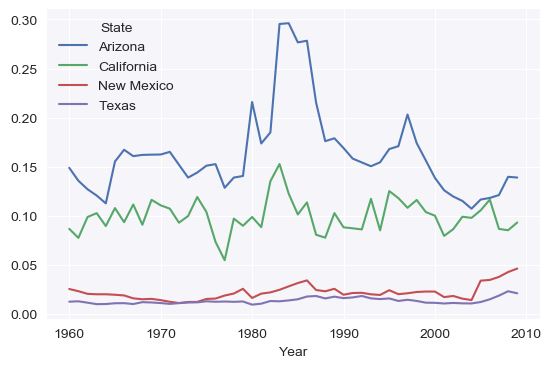

In [12]:
renewratio.plot();plt.show()

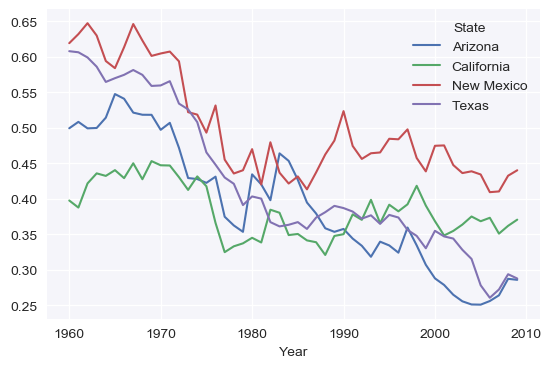

In [13]:
cleanratio.plot();plt.show()

df_disp('clean_ratio','cleanratio')

In [14]:
eng_ratio = \
energy_form.pivot_table(values='Data',index=['Year','energy form'],columns='State',aggfunc=np.sum)/\
energy_form.pivot_table(values='Data',index=['Year'],columns='State',aggfunc=np.sum)

eng_ratio.head()

State                     Arizona  California  New Mexico     Texas
Year   energy form                                                 
1960.0 Biomass           0.016512    0.026382    0.022821  0.009524
       Coal              0.000862    0.011537    0.011761  0.006211
       Geothermal        0.000000    0.000000    0.000000  0.000000
       Hydroelectricity  0.132361    0.060318    0.002567  0.002949
       Natrual gas       0.350420    0.310913    0.593707  0.595354

In [15]:
def transmat(y,y1):
    y[y == 0] = 1e-20
    y = y.ravel();y1 = y1.ravel()
    tran = np.zeros([len(y),len(y)])
    t = y1/y;t[t>=1] = 1
    t[y1 == 0] = 1
    tran[np.diag_indices(len(y))] = t
    res = 1 - t
    delta = y1 - y
    for row in range(len(y)):
        if res[row] != 0:
            for col in range(len(y)):
                if (row != col)&(delta[col] > 0):
                    tran[row,col] = res[row] * (delta[col]/delta[t>=1].sum())
    return tran

T = pd.DataFrame()
avt = pd.DataFrame()

engform.name = None
for state in eng_ratio:
    for year in range(1960,2009):
        mat = pd.DataFrame(
                transmat(eng_ratio.loc[year,state].values,eng_ratio.loc[year+1,state].values),
                #index = engform,columns = engform)
                index = pd.MultiIndex.from_product([[str(year)+'-'+str(year+1)],engform]),
                columns=pd.MultiIndex.from_product([[state],engform]))
        T = T.append(mat)


In [16]:
engform = eng_ratio.loc[1960].index
def aver_trans(state):
    T = pd.DataFrame()
    for year in range(1960,2009):
        mat = pd.DataFrame(
                transmat(eng_ratio.loc[year,state].values,eng_ratio.loc[year+1,state].values),
    #                 index = engform,columns = engform)
                index = pd.MultiIndex.from_product([[str(year)+'-'+str(year+1)],engform]),
                columns=pd.MultiIndex.from_product([[state],engform]))
        T = T.append(mat)
    avt = (T.sum(axis=0,level=1)/len(T.index.levels[0]))
    return avt

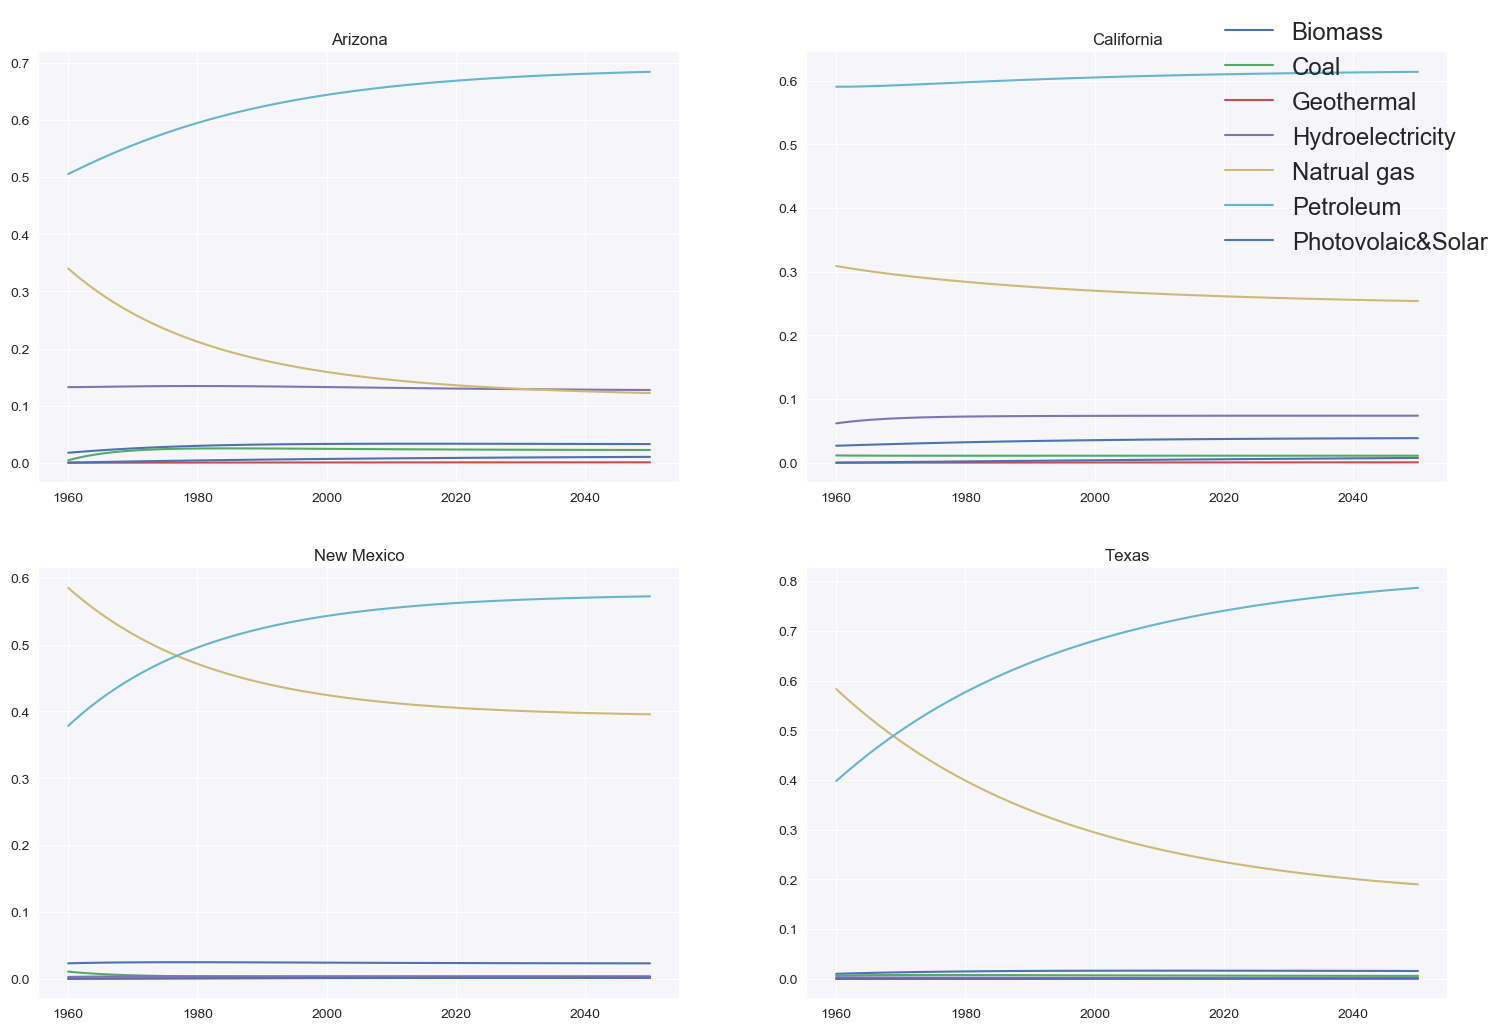

In [17]:
fig, ax = plt.subplots(2,2,figsize=(16,11))
ax = ax.flatten()

for state,i in zip(eng_ratio,range(4)):
    avt = aver_trans(state)
    pred_ratio = eng_ratio.loc[1960,state].dot(avt).unstack().reset_index().drop(columns='index')
    pred_ratio['year'] = 1960
    pred_ratio = pred_ratio.set_index('year')
    for year in range(1960,2050):
        temp = pd.DataFrame(pred_ratio.iloc[[-1],:].values.dot(avt),
                            columns=pred_ratio.columns,index=[year+1])
        pred_ratio = pred_ratio.append(temp)

    # pred_ratio.head()
    pred_ratio.plot(ax=ax[i],legend=False);
    ax[i].set_title(state)
fig.legend(fontsize='xx-large')
# fig.set_tight_layout(True)
# plt.savefig('markov_prediction.jpg')
plt.show()

line plot:energy form change along the year

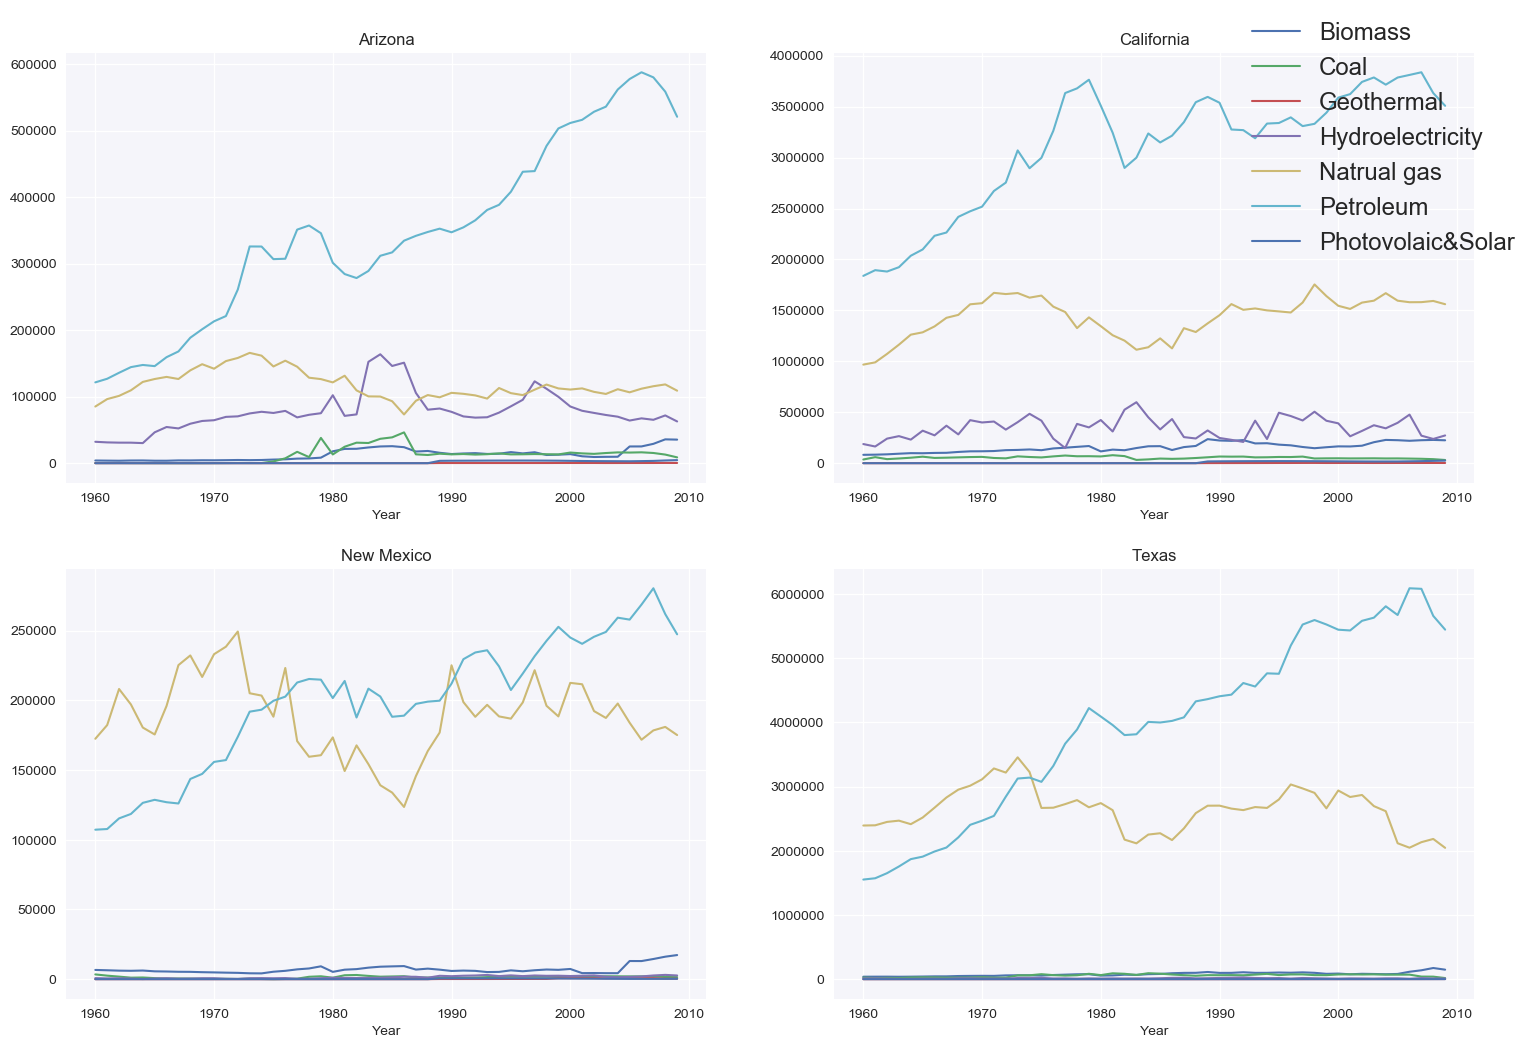

In [18]:
fig, ax = plt.subplots(2,2,figsize=(16,11),dpi = 100)
ax = ax.flatten()
for each,i in zip(agg.State.unique(),range(4)):
    energy_form.query("State == '{0}'".format(each)).\
        pivot_table('Data','Year','energy form',aggfunc=np.sum).plot(ax=ax[i],legend=False);
    ax[i].set_title(each)
#     ax[i].legend(shadow=True, fontsize='x-large')
fig.legend(fontsize='xx-large')
# fig.set_tight_layout(True)
# plt.savefig('major energy form.jpg')
plt.show()

agg.set_index('MSN').loc[['RETCB','NGTXB','TETCB','TENPV','TPOPP','GDPRX'],:].reset_index()

elec = pd.DataFrame()
for each,i in zip(msncodes.Description,range(len(msncodes.Description))):
    if 'elec' in each:
        elec = elec.append(msncodes.loc[i,:])

pd.DataFrame({'MSN':['CLTXD','PATXD','NGTXD','ESTXD'],
              'energy form':['Coal','Oil','Natural gas','Electricity']})

#### Algorithm preparation

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

#### Data preparation

In [20]:
E_total = agg[agg.MSN == 'TETCB'].pivot('Year','State','Data');
E_re = agg[agg.MSN == 'RETCB'].pivot('Year','State','Data');

E_clean = E_re + agg[agg.MSN == 'NGTXB'].pivot('Year','State','Data')

Gdp = agg[agg.MSN == 'GDPRX'].pivot('Year','State','Data')

G_0 = Gdp.iloc[0,:]

gdpn = (Gdp/G_0 - 1).drop(index=1977)

Etn = (E_total[1977:]/E_total.loc[1977,:] - 1).drop(index=1977)

et = (Etn/gdpn).dropna()

x = et.index.values.reshape(-1,1)
xfit = np.arange(x.min(),2025).reshape(-1,1)

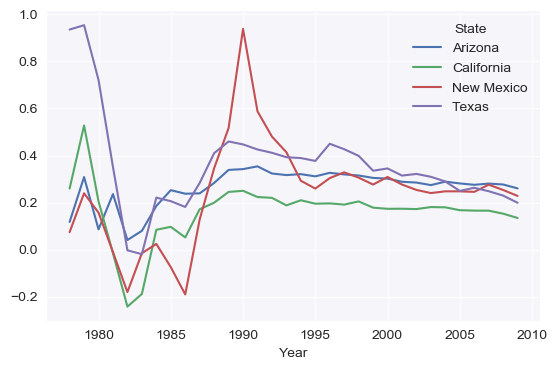

In [21]:
(Etn/gdpn).plot();
plt.show()

gdpn.plot();plt.show()
Etn.plot();plt.show()

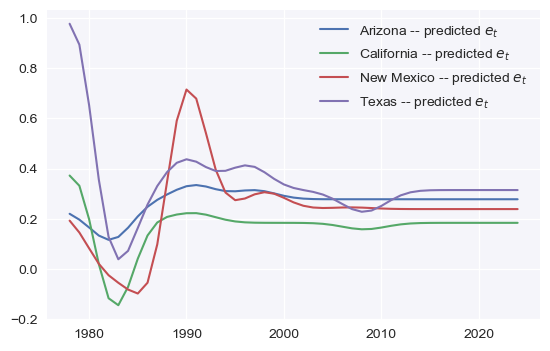

In [22]:
e_t = pd.DataFrame({'Arizona':[np.nan]*len(xfit)},index=pd.Index(xfit.flatten()))

for state in ['Arizona','California','New Mexico','Texas']:
    y = et[state].values.reshape(-1,1)

    lasso_model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))

    #plt.scatter(x,y,label=state+' actual',alpha=.5)
    lasso_model.fit(x, y)
    yfit = lasso_model.predict(xfit)
    e_t[state] = yfit
    plt.plot(xfit, yfit,label=state+' -- predicted $e_t$')

plt.legend()
# plt.savefig('elastic_coff.jpg')
plt.show()

model = LinearRegression()
model.fit(gdpn, Etn)
gdp_pred = model.predict(xfit)
gdp_pred = pd.DataFrame(gdp_pred,index=e_t.index,columns=e_t.columns)

(gdp_pred * e_t + 1)*E_total.iloc[0,:]